In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import os
jax.devices()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[CpuDevice(id=0)]

In [3]:
import pandas as pd
from src import ComputationalHypergraphDiscovery as CHD
#from ComputationalHypergraphDiscovery.Modes import LinearMode, QuadraticMode, GaussianMode
import numpy as onp
import matplotlib.pyplot as plt
import networkx as nx
import pickle
from tqdm import tqdm
import jax.numpy as np

In [4]:
additional=10

df=pd.read_csv('./BCR.csv')
df=df[df.columns[df.std(axis=0)!=0]]
relabel={n:n.replace('\\','/') for n in df.columns}
df.columns=[n.replace('\\','/') for n in df.columns]
cut=2400
df_train=df[:cut]
df_test=df[cut:]
df

,S0,S1,S2,S3,S4,S5,S6,S7,S8,S9,...,$/partial_t S1112$,$/partial_t S1113$,$/partial_t S1114$,$/partial_t S1115$,$/partial_t S1116$,$/partial_t S1117$,$/partial_t S1118$,$/partial_t S1119$,$/partial_t S1120$,$/partial_t S1121$
0,0.000002,7.304403e+05,585317.631604,3.615158e+06,6.195899e+06,238895.045577,8.643072e-10,15248.430999,166357.589035,6.986633e-10,...,3.475410e-03,1.443360e-07,3.354071e-05,2.561977e-04,7.731132e+01,2.031811e-02,1.493338e+02,3.616471e+02,4.624753e-03,8.947311e-02
1,0.000002,8.655895e+05,710888.179756,3.574970e+06,6.491118e+06,242966.103845,1.121930e-09,15863.426978,175871.708328,9.284568e-10,...,1.699553e-03,9.848641e-08,1.868933e-05,1.695635e-04,9.745335e+01,1.961951e-02,1.264184e+02,3.378304e+02,5.203614e-03,1.103019e-01
2,119649.797101,1.153809e+05,115380.207169,1.112686e+05,1.199996e+05,119999.999716,1.380535e+02,1.361351,2.606950,1.380527e+02,...,7.076956e-12,2.232804e-25,8.339580e-18,1.121754e-16,1.250482e-06,2.413633e-13,3.161855e-05,7.004705e-05,2.528237e-15,1.247526e-09
3,119700.023569,1.154077e+05,115407.275307,1.112727e+05,1.200000e+05,119999.999968,1.381435e+02,1.247712,1.960094,1.381430e+02,...,3.351184e-12,1.419783e-25,2.645328e-19,4.152657e-17,1.089697e-05,1.243332e-13,3.787004e-06,1.660261e-05,3.995675e-14,1.085608e-08
4,29981.379311,2.969648e+04,29696.495350,2.941458e+04,3.000000e+04,30000.000000,8.903415e+00,0.141142,0.175124,8.903421e+00,...,2.161153e-14,7.088757e-29,7.795995e-22,1.058060e-19,9.732877e-09,2.788445e-16,1.478142e-07,3.238233e-07,4.869930e-18,9.709106e-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5000,0.000002,1.115007e+06,974531.302015,3.526420e+06,7.075370e+06,341835.359312,1.769014e-09,16984.587413,161878.040296,1.554103e-09,...,2.343143e-04,2.910494e-08,2.970329e-06,5.085564e-05,1.635863e+02,1.075838e-02,4.861911e+01,2.130331e+02,5.524407e-03,1.715411e-01
5001,297148.127742,2.735912e+05,273583.446419,2.519036e+05,2.999944e+05,299999.936688,8.129941e+02,4.703674,14.391908,8.129719e+02,...,1.690567e-10,3.790267e-23,1.342285e-15,7.824249e-15,4.464824e-05,1.354047e-11,6.387906e-04,1.450940e-03,2.828985e-13,4.454087e-08
5002,0.000006,1.774727e+03,1420.282767,3.076068e+06,3.791961e+06,238032.895425,9.719790e-12,5020.205605,8163.711747,8.458764e-12,...,-4.378077e-03,8.244811e-07,-2.500028e-04,-5.748210e-04,-2.049486e+01,-1.760463e-03,-3.577294e+01,-6.933246e+01,2.478592e-04,-2.077291e-02
5003,0.000006,1.772895e+03,1418.532250,3.074676e+06,3.790500e+06,238033.025601,9.717387e-12,5016.628520,8156.249045,8.455209e-12,...,-4.356279e-03,8.249133e-07,-2.500649e-04,-5.732107e-04,-2.039048e+01,-1.746116e-03,-3.585287e+01,-6.938882e+01,2.543894e-04,-2.066849e-02


In [5]:
possible_edges=nx.DiGraph()
edges=[]
for f_node in tqdm(df.columns):
    if 'partial' in f_node:
        continue
    for nf_node in df.columns:
        if 'partial' in nf_node:
            edges.append((f_node,nf_node))
            edges.append((nf_node,f_node))
possible_edges.add_edges_from(edges)

  0%|          | 0/2244 [00:00<?, ?it/s]

100%|██████████| 2244/2244 [00:00<00:00, 2745.11it/s]


In [6]:
graph_discovery=CHD.GraphDiscovery.from_dataframe(df_train,normalize=True,possible_edges=possible_edges,kernels=[CHD.Modes.QuadraticMode(memory_efficient_required=True)],gamma_min=1e-9)

Converting possible edges to dense adjacency matrix


In [9]:
import glob

graphs = [pickle.load(open(path, "rb")) for path in tqdm(glob.glob('./results/*.pkl'))]
graphs = [nx.relabel_nodes(graph, relabel) for graph in graphs]

100%|██████████| 1/1 [00:00<00:00, 71.34it/s]


In [10]:
indexes_treated=[path.split('/')[-1][:-4].split('_')[-1] for path in glob.glob('./results/*.pkl')]
indexes_treated=[int(index) for index in indexes_treated]
indexes_treated

[0]

In [11]:
df_batches=pd.read_csv('./batches.csv')
df_batches

,target 1
0,$\partial_t S822$
1,$\partial_t S742$
2,$\partial_t S280$
3,$\partial_t S651$
4,$\partial_t S639$
...,...
1117,$\partial_t S457$
1118,$\partial_t S501$
1119,$\partial_t S563$
1120,$\partial_t S51$


In [12]:
#make a list of all the targets that have been treated. df_batches has 20 columns of targets, if an index was treated, df.iloc[i] was treated
treated=[]
for i in indexes_treated:
    treated+=df_batches.iloc[i][df_batches.iloc[i].notna()].tolist()
treated=[t.replace('\\','/') for t in treated]
treated

['$/partial_t S822$']

In [13]:

for g in graphs:
    graph_discovery.G=nx.compose(graph_discovery.G,g)

In [14]:
active_mode_dic = nx.get_node_attributes(graph_discovery.G, "active_modes")
for node,active_mode in active_mode_dic.items():
    missing=graph_discovery.X.shape[1]-active_mode.shape[0]
    graph_discovery.G.nodes[node]["active_modes"] =jax.numpy.pad(active_mode,(0,missing),'constant',constant_values=(0,0))

In [15]:
k_dic = nx.get_node_attributes(graph_discovery.G, "kernel_index")
is_zero=np.array([k_dic.get(name, -1) for name in treated])==-1
is_zero

Array([False], dtype=bool)

In [16]:
is_zero_mode=np.array([np.all(graph_discovery.G.nodes[name].get("active_modes",np.array([0]))==0) for name in treated])
is_zero_mode

Array([False], dtype=bool)

In [17]:
is_zero=np.logical_or(is_zero,is_zero_mode)
is_zero

Array([False], dtype=bool)

In [18]:
treated_and_non_zero=[t for t,z in zip(treated,is_zero) if not z]

In [17]:
pred = graph_discovery.predict(treated_and_non_zero,df_test.values)

In [18]:
truth=df_test[treated_and_non_zero].values
truth.shape

(2605, 82)

In [19]:
std=onp.std(truth,axis=0)

In [20]:
pred.shape

(2605, 82)

In [21]:
errors= jax.numpy.quantile((truth-pred)**2,0.99,axis=0)/std**2


In [22]:
worst_res = graph_discovery.G.nodes[treated_and_non_zero[np.argmax(errors)]]
worst_res

{'active_modes': Array([1., 1., 1., ..., 0., 0., 0.], dtype=float64),
 'kernel_index': 0,
 'type': 'quadratic',
 'gamma': 0.00014998847214519015,
 'coeff': Array([ 0.05272845, -0.07050311,  0.22271914, ...,  0.02815014,
        -0.06413177,  0.15004197], dtype=float64)}

In [23]:
np.mean(errors_per_sample[errors_per_sample<20])

NameError: name 'errors_per_sample' is not defined

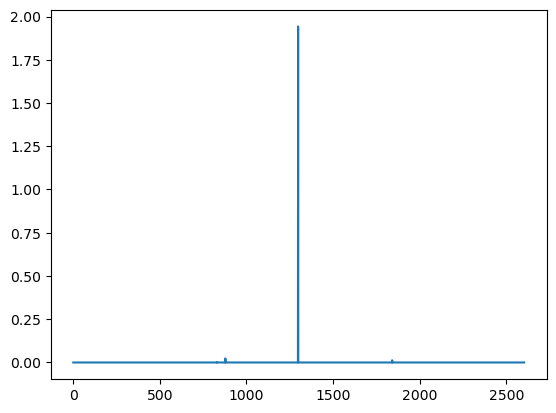

In [24]:
errors_per_sample= jax.numpy.median((truth-pred)**2/std[None,:]**2,axis=1)
plt.plot(errors_per_sample[errors_per_sample<1000])

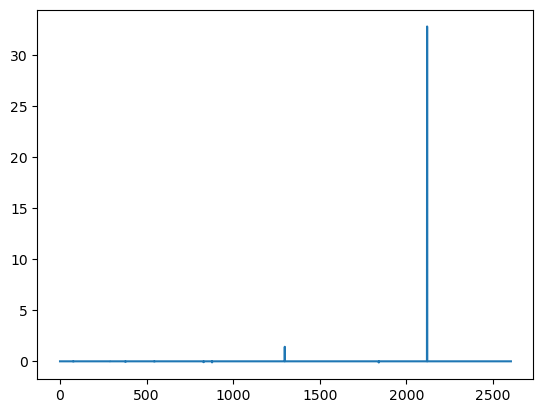

In [25]:
plt.plot((truth-pred)[:,np.argmax(errors)]/std[np.argmax(errors)])

In [26]:
np.sum(graph_discovery.G.nodes[treated_and_non_zero[1]]['active_modes'])

Array(16., dtype=float64)

In [27]:
errors[::10]

Array([8.12409230e-12, 3.31782175e-15, 1.07268761e-12, 4.97261177e-14,
       1.92639534e-12, 1.45358860e-13, 4.61460441e-16, 1.82783951e-11,
       7.87782184e-15], dtype=float64)

In [28]:
np.mean(np.log(errors))

Array(-30.93150515, dtype=float64)

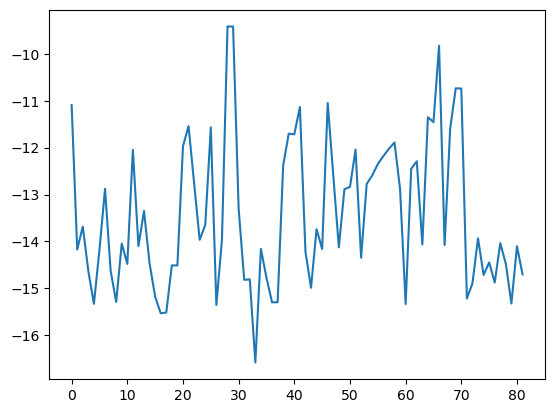

In [29]:
plt.plot(jax.numpy.log10(errors))

In [30]:
errors.shape

(82,)

In [19]:
true_graph=pickle.load(open('./BCR.pkl','rb'))
true_graph=nx.relabel_nodes(true_graph, relabel)

In [28]:
onp.sort([int(n[1:]) for n in nx.ancestors(true_graph,treated_and_non_zero[0])])

array([  1,   4, 341, 349, 468, 792, 812, 821, 822, 875, 926])

In [29]:
onp.sort([int(n[1:]) for n in nx.ancestors(graph_discovery.G,treated_and_non_zero[0])])

array([   2,    9,   15,   18,   66,   81,  101,  157,  164,  169,  172,
        182,  193,  216,  218,  222,  241,  273,  288,  312,  327,  363,
        369,  375,  397,  416,  418,  419,  420,  435,  440,  468,  487,
        498,  520,  537,  549,  573,  612,  621,  629,  636,  663,  684,
        697,  718,  720,  728,  735,  773,  778,  787,  792,  807,  822,
        831,  866,  895,  917,  926,  965,  992, 1044, 1045, 1047, 1073,
       1114, 1118])

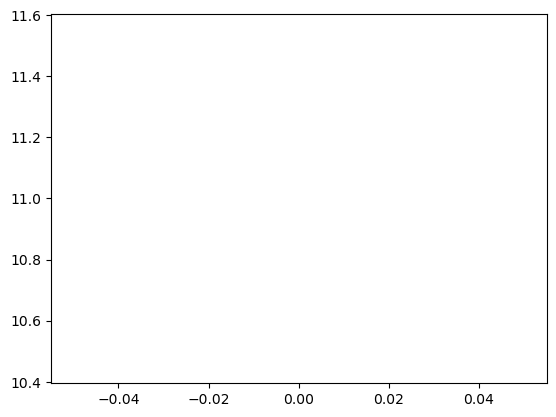

In [20]:
ancestors=np.array([len(nx.ancestors(true_graph,node)) for node in treated_and_non_zero])
plt.plot(ancestors)

In [33]:
#solve 2400=n(n+3)/2
n=int((onp.sqrt(1+8*2400)-3)/2)
n

67

In [34]:
n*(n+3)/2

2345.0

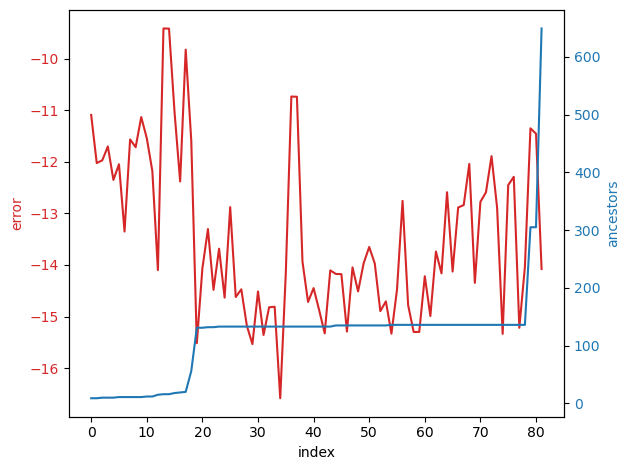

In [35]:
#plot two plots with different y axis
fig, ax1 = plt.subplots()
indexes=np.argsort(ancestors)

color = 'tab:red'
ax1.set_xlabel('index')
ax1.set_ylabel('error', color=color)
ax1.plot(np.log10(errors)[indexes], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('ancestors', color=color)  # we already handled the x-label with ax1
ax2.plot((ancestors)[indexes], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [36]:
true_graph.nodes

NodeView(('S0', '$/partial_t S0$', 'S1', '$/partial_t S1$', 'S2', '$/partial_t S2$', 'S3', '$/partial_t S3$', 'S4', '$/partial_t S4$', 'S5', '$/partial_t S5$', 'S6', '$/partial_t S6$', 'S7', '$/partial_t S7$', 'S8', '$/partial_t S8$', 'S9', '$/partial_t S9$', 'S10', '$/partial_t S10$', 'S11', '$/partial_t S11$', 'S12', '$/partial_t S12$', 'S13', '$/partial_t S13$', 'S14', '$/partial_t S14$', 'S15', '$/partial_t S15$', 'S16', '$/partial_t S16$', 'S17', '$/partial_t S17$', 'S18', '$/partial_t S18$', 'S19', '$/partial_t S19$', 'S20', '$/partial_t S20$', 'S21', '$/partial_t S21$', 'S22', '$/partial_t S22$', 'S23', '$/partial_t S23$', 'S24', '$/partial_t S24$', 'S25', '$/partial_t S25$', 'S26', '$/partial_t S26$', 'S27', '$/partial_t S27$', 'S28', '$/partial_t S28$', 'S29', '$/partial_t S29$', 'S30', '$/partial_t S30$', 'S31', '$/partial_t S31$', 'S32', '$/partial_t S32$', 'S33', '$/partial_t S33$', 'S34', '$/partial_t S34$', 'S35', '$/partial_t S35$', 'S36', '$/partial_t S36$', 'S37', '$/p

In [37]:
true_graph.edges

OutEdgeView([('S0', '$/partial_t S0$'), ('S0', '$/partial_t S1$'), ('S0', '$/partial_t S6$'), ('S0', '$/partial_t S2$'), ('S0', '$/partial_t S9$'), ('S0', '$/partial_t S7$'), ('S0', '$/partial_t S12$'), ('S0', '$/partial_t S13$'), ('S0', '$/partial_t S14$'), ('S0', '$/partial_t S8$'), ('S0', '$/partial_t S17$'), ('S0', '$/partial_t S15$'), ('S0', '$/partial_t S16$'), ('S0', '$/partial_t S24$'), ('S0', '$/partial_t S30$'), ('S0', '$/partial_t S23$'), ('S0', '$/partial_t S25$'), ('S0', '$/partial_t S31$'), ('S0', '$/partial_t S34$'), ('S0', '$/partial_t S28$'), ('S0', '$/partial_t S35$'), ('S0', '$/partial_t S40$'), ('S0', '$/partial_t S42$'), ('S0', '$/partial_t S54$'), ('S0', '$/partial_t S39$'), ('S0', '$/partial_t S41$'), ('S0', '$/partial_t S43$'), ('S0', '$/partial_t S46$'), ('S0', '$/partial_t S50$'), ('S0', '$/partial_t S55$'), ('S0', '$/partial_t S47$'), ('S0', '$/partial_t S48$'), ('S0', '$/partial_t S51$'), ('S0', '$/partial_t S69$'), ('S0', '$/partial_t S71$'), ('S0', '$/part

In [38]:
graph_discovery.G.edges

OutEdgeView([('S0', '$/partial_t S20$'), ('S0', '$/partial_t S21$'), ('S0', '$/partial_t S22$'), ('S0', '$/partial_t S84$'), ('S0', '$/partial_t S33$'), ('S0', '$/partial_t S10$'), ('S0', '$/partial_t S11$'), ('S0', '$/partial_t S14$'), ('S0', '$/partial_t S15$'), ('S0', '$/partial_t S16$'), ('S0', '$/partial_t S57$'), ('S0', '$/partial_t S59$'), ('S0', '$/partial_t S163$'), ('S0', '$/partial_t S95$'), ('S0', '$/partial_t S126$'), ('S0', '$/partial_t S129$'), ('S0', '$/partial_t S156$'), ('S0', '$/partial_t S0$'), ('S0', '$/partial_t S1$'), ('S0', '$/partial_t S2$'), ('S0', '$/partial_t S6$'), ('S0', '$/partial_t S9$'), ('S1', '$/partial_t S20$'), ('S1', '$/partial_t S21$'), ('S1', '$/partial_t S22$'), ('S1', '$/partial_t S82$'), ('S1', '$/partial_t S84$'), ('S1', '$/partial_t S10$'), ('S1', '$/partial_t S11$'), ('S1', '$/partial_t S57$'), ('S1', '$/partial_t S59$'), ('S1', '$/partial_t S163$'), ('S1', '$/partial_t S95$'), ('S1', '$/partial_t S126$'), ('S1', '$/partial_t S129$'), ('S1'

In [39]:
#compute the true positives and false negatives. For each edge in graph_discovery.G, if it is in true_graph, it is a true positive, otherwise it is a false positive
#true_graph is a networkx graph, graph_discovery.G is a networkx graph
true_positives=0
false_positives=0
false_negatives=0
true_negatives=0
for edge in graph_discovery.G.edges:
    if edge in true_graph.edges:
        true_positives+=1
    else:
        false_positives+=1

for edge in true_graph.edges:
    if edge not in graph_discovery.G.edges:
        if edge[1] in treated and len(nx.ancestors(true_graph,edge[1]))<69:
            false_negatives+=1
#compute true negatives


false_negatives

1540

In [40]:
true_positives

1330

In [41]:
false_positives

4742

# No pruning

In [42]:
active_mode = np.array([1]*(graph_discovery.X.shape[1]//2)+[0]*(graph_discovery.X.shape[1]//2))
K_mat=graph_discovery.kernels[0](graph_discovery.X,graph_discovery.X,active_mode)

In [43]:
gamma = -np.linalg.eigvalsh(K_mat)[0]*2

In [44]:
ybs=jax.scipy.linalg.solve(K_mat+gamma*np.eye(K_mat.shape[0]),graph_discovery.X,assume_a='pos')
ybs

Array([[ 0.00186861,  0.00774787,  0.00842719, ...,  0.01440706,
         0.00630739, -0.04443163],
       [-0.002234  , -0.01032468, -0.01135911, ..., -0.02440178,
         0.02869952,  0.05869252],
       [-0.00073848,  0.00043968,  0.00161683, ...,  0.0003194 ,
         0.00145501,  0.00033377],
       ...,
       [ 0.01344884, -0.00279767, -0.00082302, ..., -0.02306134,
         0.13900466,  0.03221073],
       [-0.00270629,  0.00026317, -0.00072329, ..., -0.0002951 ,
        -0.00026564,  0.00053216],
       [ 0.00356438, -0.00047125,  0.00062743, ...,  0.00042393,
         0.000693  , -0.00037533]], dtype=float64)

In [45]:
indexes_treated=np.array([graph_discovery.name_to_index[name] for name in treated_and_non_zero])
ybs=ybs[:,indexes_treated]
ybs.shape

(2400, 82)

In [46]:
df_test[treated_and_non_zero].values.shape

(2605, 82)

In [47]:
graph_discovery.X.shape

(2400, 2244)

In [48]:
K_pred=graph_discovery.kernels[0](df_test.values,graph_discovery.X,active_mode)

In [49]:
pred_no_pruning=K_pred@ybs

In [50]:
diffs_no_pruning=(df_test[treated_and_non_zero].values-pred_no_pruning)

In [51]:
errors= jax.numpy.median((diffs_no_pruning)**2,axis=0)/std**2

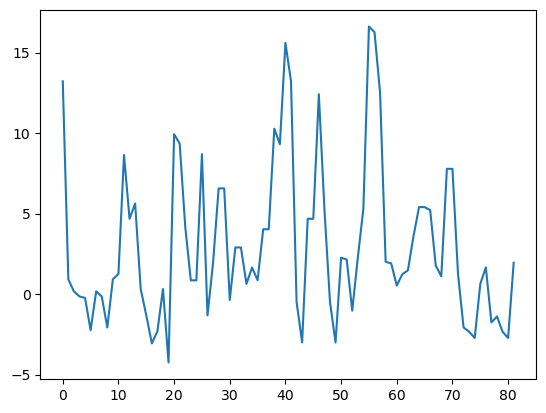

In [52]:
plt.plot(np.log10(errors))

In [53]:
np.mean(np.log10(errors)>0)

Array(0.71951216, dtype=float32)

In [56]:
int(10**np.mean(np.log10(errors))*100)

96124